<a href="https://colab.research.google.com/github/HippocampusTeam/DNNT-TensorFlow/blob/Pruning/DNNT_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import csv
import time
import datetime

import tensorflow as tf
import tensorflow.compat.v1 as tf1
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

TensorFlow functions

In [2]:
@tf.function
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_fn(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

    return loss


@tf.function
def test_step(x, y, model, val_acc_metric):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    loss = loss_fn(y, val_logits)

    test_loss(loss)
    test_accuracy(y, val_logits)

Test

In [3]:
# Read data in from file
with open("/content/drive/MyDrive/DNNT/data/banknotes.csv") as f:
    reader = csv.reader(f)
    next(reader)

    data = []
    for row in reader:
        data.append({
            "evidence": [float(cell) for cell in row[:4]],
            "label": 1 if row[4] == "0" else 0
        })

# Separate data into training and testing groups
evidence = [row["evidence"] for row in data]
labels = [row["label"] for row in data]
X_training, X_testing, y_training, y_testing = train_test_split(
    evidence, labels, test_size=0.4
)

In [4]:
# Create a neural network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# Train neural network
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(X_training, y_training, epochs=15)
#
# # Evaluate how well model performs
# model.evaluate(X_testing, y_testing, verbose=2)

Epoch 1/15
26/26 [==============================] - 1s 1ms/step - loss: 1.0353 - accuracy: 0.5131
Epoch 2/15
26/26 [==============================] - 0s 1ms/step - loss: 1.0280 - accuracy: 0.5252
Epoch 3/15
26/26 [==============================] - 0s 1ms/step - loss: 0.9902 - accuracy: 0.5450
Epoch 4/15
26/26 [==============================] - 0s 1ms/step - loss: 0.8737 - accuracy: 0.5652
Epoch 5/15
26/26 [==============================] - 0s 2ms/step - loss: 0.8139 - accuracy: 0.5721
Epoch 6/15
26/26 [==============================] - 0s 1ms/step - loss: 0.7787 - accuracy: 0.6152
Epoch 7/15
26/26 [==============================] - 0s 1ms/step - loss: 0.7825 - accuracy: 0.6293
Epoch 8/15
26/26 [==============================] - 0s 1ms/step - loss: 0.7437 - accuracy: 0.6109
Epoch 9/15
26/26 [==============================] - 0s 1ms/step - loss: 0.7145 - accuracy: 0.6247
Epoch 10/15
26/26 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.6483
Epoch 11/15
26/26 [

In [5]:
def graph2D(model, index, x_train, y_train, n):
    weights = model.get_weights()
    if len(index) == 3:
        weights[index[0]][index[1]][index[2]] = n
    else:
        weights[index[0]][index[1]] = n
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    if len(index) == 3:
        return (model.get_weights()[index[0]][index[1]][index[2]], np.mean(loss))
    else:
        return (model.get_weights()[index[0]][index[1]], np.mean(loss))

In [7]:
x = list()
y = list()
def add_weight(index):
    x.append(list())
    y.append(list())
    model_copy = tf.keras.models.clone_model(model)
    for i in np.linspace(-2, 2, 50):
        cur = graph2D(model_copy, index, X_testing, y_testing, i)
        x[-1].append(cur[0])
        y[-1].append(cur[1])

In [ ]:
def add_all():
    w = model.get_weights()
    for i in range(len(w)):
        for j in range(len(w[i])):
            if isinstance(w[i][j], np.ndarray):
                for k in range(len(w[i][j])):
                    add_weight((i, j, k))
            else:
                add_weight((i, j))
add_all()

In [ ]:
print(model.get_weights())

[array([[-0.7059722 , -0.93293357,  0.27436855, -1.0327246 ],
       [ 0.5638637 ,  0.6982932 ,  0.52283686, -0.33282334],
       [ 0.18857582, -0.5283083 ,  0.13139778, -0.25498453],
       [ 0.14558339,  0.39641026,  0.41626185, -0.1980442 ]],
      dtype=float32), array([-0.12324585,  0.2851991 , -0.01535906,  0.30080074], dtype=float32), array([[ 0.06684455],
       [-0.23977357],
       [ 1.0856732 ],
       [-1.065724  ]], dtype=float32), array([0.15303977], dtype=float32)]


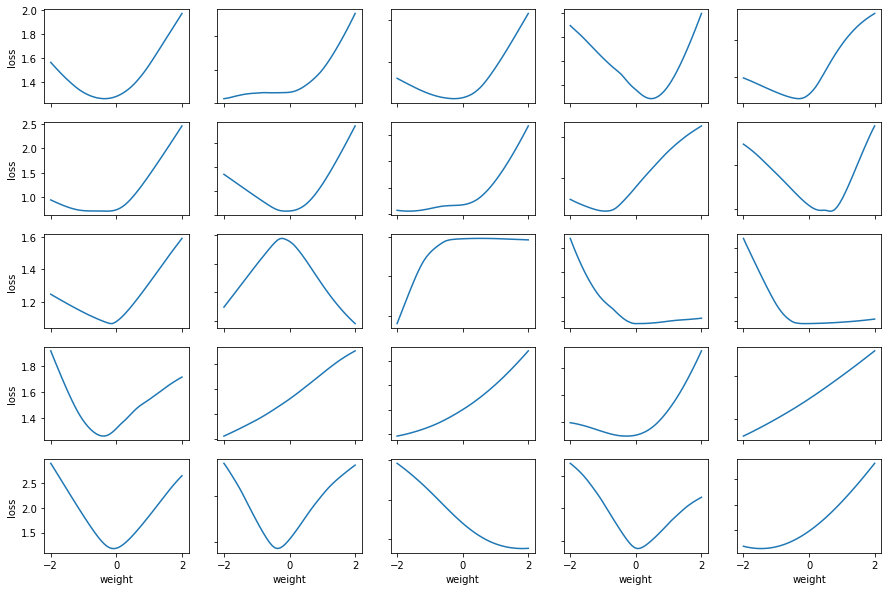

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10))
for i in range(25):
    axs[i // 5, i % 5].plot(x[i], y[i])

for ax in axs.flat:
    ax.set(xlabel='weight', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [10]:
def graph3D(model, index1, index2, x_train, y_train, n, m):
    weights = model.get_weights()
    if len(index1) == 3:
        weights[index1[0]][index1[1]][index1[2]] = n
    else:
        weights[index1[0]][index1[1]] = n
    if len(index2) == 3:
        weights[index2[0]][index2[1]][index2[2]] = m
    else:
        weights[index2[0]][index2[1]] = m
    model.set_weights(weights)
    predictions = model.predict(x_train)
    loss = tf.keras.losses.binary_crossentropy(y_train, predictions)
    return (n, m, np.mean(loss))

In [46]:
from tqdm import tqdm
x = list()
y = list()
z = list()
x_p = list()
y_p = list()
z_p = list()
def add_weights3D(index1, index2, add_plain=True):
    x.append(list())
    y.append(list())
    z.append(list())
    x_p.append(list())
    y_p.append(list())
    z_p.append(list())
    model_copy = tf.keras.models.clone_model(model)
    for i in tqdm(np.linspace(-2, 2, 50)):
        for j in np.linspace(-2, 2, 50):
            cur = graph3D(model_copy, index1, index2, X_testing, y_testing, i, j)
            x[-1].append(cur[0])
            y[-1].append(cur[1])
            z[-1].append(cur[2])
    if add_plain:
        for i in tqdm(np.linspace(-2, 2, 50)):
            cur = graph3D(model_copy, index1, index2, X_testing, y_testing, i, 0)
            x_p[-1].append(cur[0])
            y_p[-1].append(cur[1])
            z_p[-1].append(cur[2])

100%|██████████| 50/50 [00:04<00:00, 11.35it/s]


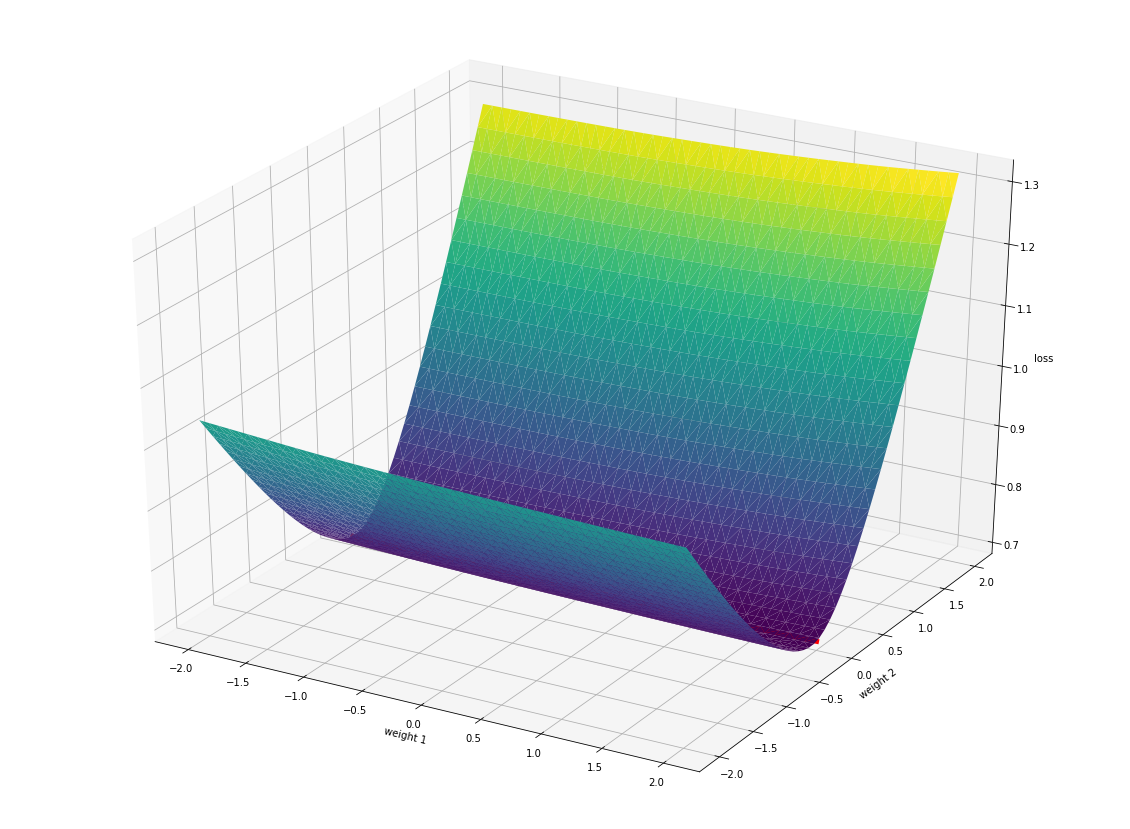

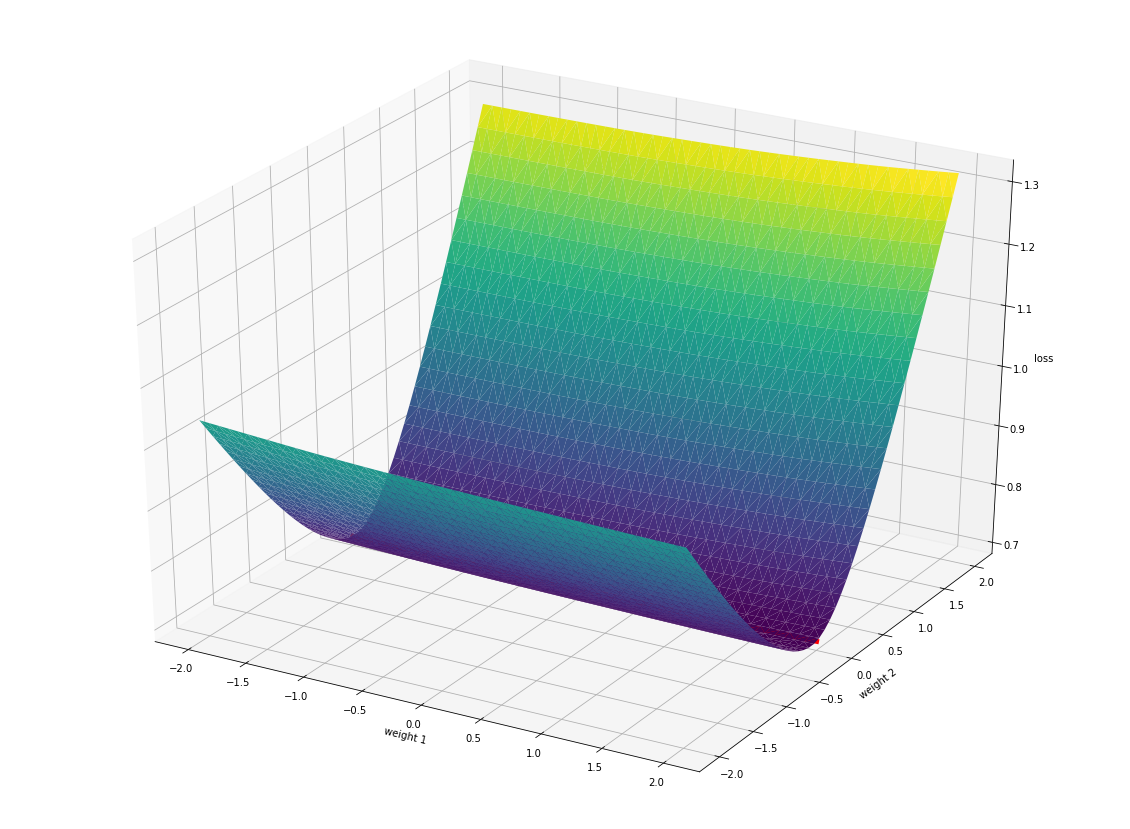

In [59]:
def plot3D(index1, index2, add_plain=True, cords=None):
    add_weights3D(index1, index2, add_plain=add_plain)
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(x[-1], y[-1], z[-1],
                    cmap='viridis', edgecolor='none')
    ax.plot3D(x_p[-1], y_p[-1], z_p[-1], 'red', linewidth=5)
    ax.set_xlabel('weight 1')
    ax.set_ylabel('weight 2')
    ax.set_zlabel('loss')
    if cords is not None:
        ax.view_init(cords[0], cords[1])

plot3D((0, 0, 0), (0, 0, 1))